# Homework1
大数据学院 22210980119 于鹏

## Qustion1

首先对问题进行整体的分析。

我们的任务是每四个月更新一次投资组合，使用过去五年的数据，通过约束期望收益率、权重和为1来求解马科维茨组合模型，将得到的权重用于求解时刻（比如2015.5.1）及后四个月的投资，可以设定最初时刻有1元，然后计算每一天的收益率，绘制出手中资产随日期的变化曲线，同理可绘出“持有HS300”的资产变化曲线。

具体求解上，通过pandas读取数据，通过numpy进行数值的计算，由于涉及到了很多日期加减相关的操作，故而使用了datatime和dateutil库；为了求解马科维茨组合模型，使用了scipy提供的minimize函数。

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import scipy.optimize as sco
from dateutil.relativedelta import relativedelta
import math

In [2]:
origin_data = pd.read_csv('his_close_price-1.csv', encoding='gbk')

下个代码块是为了将得到的DataFrame类的index（行索引）修改为日期，便于后续的日期过滤查询、取得合法数据。由于原始数据是逆序的，所以需要颠倒过来，让2010年在前面。

将index设定为trade_date之后，便可以删除掉原来的这一列。

In [3]:
filtered_data = origin_data.iloc[::-1]
filtered_data['trade_date'] = pd.to_datetime(filtered_data['trade_date'], 
    format='%Y%m%d')
filtered_data.index = filtered_data['trade_date'].tolist()
filtered_data.pop('trade_date')

2010-01-04   2010-01-04
2010-01-05   2010-01-05
2010-01-06   2010-01-06
2010-01-07   2010-01-07
2010-01-08   2010-01-08
                ...    
2021-12-27   2021-12-27
2021-12-28   2021-12-28
2021-12-29   2021-12-29
2021-12-30   2021-12-30
2021-12-31   2021-12-31
Name: trade_date, Length: 2917, dtype: datetime64[ns]

In [5]:
filtered_data.shape

(2917, 51)

马科维茨模型中都是对收益率的计算，因此我们需要将股票价格首先转换成每日收益率，可以调用pandas提供的pct_change()函数，该函数可以将一行数据与前一行作差后作比，恰好是我们需要求的日收益率；另外，该函数在默认情况下会选用'ffill'模式对NaN进行填充，也即将上一个有效数据填充到当前NaN中，由于数据量相对较大，所以这样不会带来较大的误差；另外，由于第一行没有数据，所以我们通过dropna()方法来去掉第一行的NaN，避免影响后续计算。

In [4]:
filtered_return = filtered_data.iloc[:, 1:].pct_change().dropna()

通过.head()检查一下结果：

In [7]:
filtered_return.head()

,600999.SH,601001.SH,601002.SH,601003.SH,601005.SH,601006.SH,601007.SH,601008.SH,601009.SH,601088.SH,...,601898.SH,601899.SH,601918.SH,601919.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601998.SH
2010-01-06,-0.022366,0.014396,-0.023486,0.044525,0.006920,0.000984,-0.005903,-0.017699,-0.020011,0.001423,...,0.009306,-0.014257,-0.003238,0.002132,-0.016103,-0.004096,-0.011521,0.011842,-0.003268,-0.028152
2010-01-07,-0.008289,-0.019911,-0.035443,-0.021889,-0.025773,-0.021632,-0.020190,-0.029601,-0.016120,-0.023309,...,-0.026950,-0.017562,-0.034651,-0.029787,-0.014730,-0.008226,-0.018648,-0.011704,-0.022951,-0.034005
2010-01-08,0.020729,-0.023125,0.013123,-0.017668,0.047619,-0.001005,0.008485,0.006631,0.021846,-0.012806,...,0.006560,-0.008412,-0.017947,-0.004386,0.003322,-0.021255,0.004751,-0.010526,-0.005593,0.009126
2010-01-11,0.022273,-0.015708,-0.010363,0.020384,0.020202,0.002012,0.025240,0.003953,-0.038482,0.011498,...,-0.005069,0.009544,-0.001142,0.034508,0.016556,0.006356,0.009456,0.021277,0.005624,-0.010336
2010-01-12,0.004806,0.008092,0.022251,0.021152,0.001650,0.039157,0.017585,0.028871,0.000000,0.009910,...,0.014556,0.009454,0.018296,0.053939,0.004886,0.008947,0.011710,0.032552,0.019016,0.002611


同样地，需要对沪深指数进行求算：

In [5]:
filtered_HS = filtered_data.iloc[:, 0].pct_change()

In [6]:
filtered_HS.head()

2010-01-04         NaN
2010-01-05    0.008149
2010-01-06   -0.006260
2010-01-07   -0.019841
2010-01-08    0.002498
Name: 沪深300, dtype: float64

从数据实际情况来看，日收益率的第二行也存在一个NaN，实际上前两行都会被dropna()方法过滤，所以这里我们也把沪深指数的日变化率、原数据进行同样的数据，只损失了两天的数据，不会影响我们整体的结果：

In [7]:
filtered_data = filtered_data.iloc[2:, :]  # 去掉前两天，手动过滤
filtered_HS = filtered_HS.iloc[2:]

In [8]:
filtered_data.head()

,沪深300,600999.SH,601001.SH,601002.SH,601003.SH,601005.SH,601006.SH,601007.SH,601008.SH,601009.SH,...,601898.SH,601899.SH,601918.SH,601919.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601998.SH
2010-01-06,3541.73,30.16,47.21,7.90,8.68,5.82,10.17,8.42,7.77,18.61,...,14.10,9.68,18.47,14.10,6.11,19.45,4.29,7.69,9.15,7.94
2010-01-07,3471.46,29.91,46.27,7.62,8.49,5.67,9.95,8.25,7.54,18.31,...,13.72,9.51,17.83,13.68,6.02,19.29,4.21,7.60,8.94,7.67
2010-01-08,3480.13,30.53,45.20,7.72,8.34,5.94,9.94,8.32,7.59,18.71,...,13.81,9.43,17.51,13.62,6.04,18.88,4.23,7.52,8.89,7.74
2010-01-11,3482.05,31.21,44.49,7.64,8.51,6.06,9.96,8.53,7.62,17.99,...,13.74,9.52,17.49,14.09,6.14,19.00,4.27,7.68,8.94,7.66
2010-01-12,3534.92,31.36,44.85,7.81,8.69,6.07,10.35,8.68,7.84,NaN,...,13.94,9.61,17.81,14.85,6.17,19.17,4.32,7.93,9.11,7.68


In [9]:
filtered_HS.head()

2010-01-06   -0.006260
2010-01-07   -0.019841
2010-01-08    0.002498
2010-01-11    0.000552
2010-01-12    0.015184
Name: 沪深300, dtype: float64

设定题目要求的数据：

In [10]:
num_stocks = 50

risk_free_rate = 0.03
target_rate = 0.06

设定要计算的年份，因为range()左开右闭，所以把end设置为2023年：

In [11]:
start_year = 2015
end_year = 2023

在计算之前，我们可以先用蒙特卡洛模拟的方法看一下效果,具体的细节在注释中进行了说明：

In [15]:
def monte_carlo(cur_year, cur_month):
    cur_data = None
    # 构造出当前的日期
    cur_date = datetime(cur_year, cur_month, 1)
    # python自带的datetime模块无法直接进行年份的加减，因此这里选择了更方便的dateutil，可以通过relativedlta进行计算
    filter_index = (filtered_return.index >= 
        cur_date + relativedelta(years=-5)) * (filtered_return.index < cur_date)
    cur_data = filtered_return[filter_index]

    port_returns = []  # 收益率
    port_sigma = []  # 标准差
    
    # 开始循环，每次随机生成一组权重，然后计算其收益率和标准差
    for k in range(2000):
        weights = np.random.random(num_stocks) # 50支股票 shape (50, 1)
        weights /= (weights.sum())
        # np.mat(cur_data.mean())构造shape(1, 50) matrix
        # 按照252天来算
        port_returns.append(np.sum(cur_data.mean() * 252 * weights))
        port_sigma.append(np.sqrt(np.dot(weights.T, 
            np.dot(cur_data.cov() * 252, weights))))

    port_returns = np.array(port_returns)
    port_sigma = np.array(port_sigma)

    plt.figure(figsize=(8, 4))
    # 绘制随机权重结果
    plt.scatter(port_sigma, port_returns, 
        c=(port_returns - risk_free_rate) / port_returns, marker='x')
    plt.grid(True)
    plt.xlabel('Expected volatility')
    plt.ylabel('Expected return')
    plt.colorbar(label='Sharpe ratio')

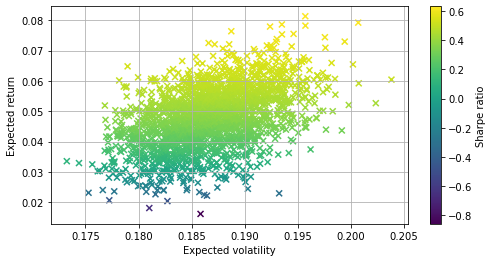

In [15]:
monte_carlo(2022, 1)

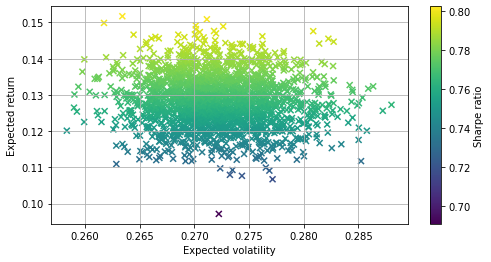

In [16]:
monte_carlo(2018, 5)

上述图片直接验证了马科维茨模型的有效性，我们随机地选择一些权重，大量采样作图后确实可以得到近似的efficient frontier和feasible set，看起来有曲线的形状；由于电脑算力限制，没有设置更多的点。

其实在完成作业的过程中，我还尝试在上面的图中一并绘制资本市场线和有效前沿，但发现资本市场线上的收益率远远高于随机权重得到的收益率，比如能达到1600%的结果，导致随机生成的权重点只占据了很小的一部分空间，我分析这是因为我们求解资本市场线的时候是在找最优的结果，因此的确能找到这样一个非常大的数据，但是这个数据是我们“过拟合”出来的（这里引用机器学习里的概念），所以虽然看起来数值很大很美好，但在未来使用时候并不会获得这样高的收益率，后面部分我们求解带无风险资产的投资组合时的测试结果证实了这一点。

现在，我们开始正式的求解计算，这里写了一个cal_mean_var()函数来求解某一日期的组合的权重，后续可以循环调用这个函数，生成各个日期的结果，比较方便。具体的实现细节参见代码块中的注释：

In [18]:
def cal_mean_var(cur_year, cur_month):
    # 首先设置约束条件，分别是各个股票权重之和等于1，以及收益率要等于我们预期的6%
    # 调用scipy函数求解过程中也要计算预期收益率
    # 因此这里创建了一个statistics_cur_data()函数，封装起来方便计算
    cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1},
    {'type':'eq','fun':lambda x:statistics_cur_data(x)[0] - target_rate}
    )

    # 由于允许做空，所以没有bounds参数的约束条件
    bnds = None
    
    # 统计收益率、标准差，夏普比
    def statistics_cur_data(weights):
        # weight shape should be [50, 1]
        weights = np.array(weights)
        # 因为给的预期是年收益率，所以把日收益率的平均结果乘以一年的交易日期数目252
        port_return = np.sum(cur_data.mean() * weights) * 252
        port_sigma = np.sqrt(np.dot(weights.T, 
            np.dot(cur_data.cov() * 252, weights)))
        return np.array([port_return, port_sigma, port_return / port_sigma])
     
    # 求解预期收益率约束下的股票权重
    # 需要设置一个最小化方差的函数，作为参数传入到sco.minimize中
    def min_variance(weights):
        return statistics_cur_data(weights)[1]
    
    print('cur_year {year} cur_month {month}'.format(year=cur_year, 
        month=cur_month))

    cur_date = datetime(cur_year, cur_month, 1)
    filter_index = (filtered_return.index >= cur_date + 
        relativedelta(years=-5)) * (filtered_return.index < cur_date)
    cur_data = filtered_return[filter_index]
    assert cur_data is not None
    
    # num_stocks * [1. / num_stocks,]可以构造出长为num_stocks的平均权重列表
    opts = sco.minimize(min_variance, num_stocks * [1. / num_stocks,], 
        method='SLSQP', bounds=bnds, constraints=cons)
    # print(statistics_cur_data(opts['x']))
    
    # 开始对未来四个月进行统计计算，本函数内部只计算出来未来四个月每日的权重
    # 把该数据return给外部，符合这一函数的作用，避免了混乱，也便于debug
    check_index = (filtered_return.index >= cur_date) * \
        (filtered_return.index <= (cur_date + relativedelta(months=4))) 
    check_data = filtered_return[check_index]
    cur_weight = opts['x']
    true_return = np.dot(check_data, cur_weight)
    # 沪深指数也会在作图中用到，所以也return出去
    check_HS = filtered_HS[check_index]
    return check_data.index, true_return, check_HS

循环求解：

In [31]:
x_list = []
y_list = []
hs_list = []
for cur_year in range(start_year, end_year, 1):
    for cur_month in range(1, 13, 4):
        cur_x, cur_y, cur_HS = cal_mean_var(cur_year, cur_month)
        x_list.extend(cur_x.tolist())
        y_list.extend(cur_y.tolist())
        hs_list.extend(cur_HS.tolist())

cur_year 2015 cur_month 1
cur_year 2015 cur_month 5
cur_year 2015 cur_month 9
cur_year 2016 cur_month 1
cur_year 2016 cur_month 5
cur_year 2016 cur_month 9
cur_year 2017 cur_month 1
cur_year 2017 cur_month 5
cur_year 2017 cur_month 9
cur_year 2018 cur_month 1
cur_year 2018 cur_month 5
cur_year 2018 cur_month 9
cur_year 2019 cur_month 1
cur_year 2019 cur_month 5
cur_year 2019 cur_month 9
cur_year 2020 cur_month 1
cur_year 2020 cur_month 5
cur_year 2020 cur_month 9
cur_year 2021 cur_month 1
cur_year 2021 cur_month 5
cur_year 2021 cur_month 9
cur_year 2022 cur_month 1
cur_year 2022 cur_month 5
cur_year 2022 cur_month 9


统计作图时需要用到的数据，假定初始时刻有1元的资产，可以计算出每日我们手中的资产价值：

In [32]:
stock_asset = []
hs_asset = []

start_stock = 1
start_hs = 1
for cur_y, cur_hs in zip(y_list, hs_list):
    start_stock = start_stock * (1 + cur_y)
    start_hs = start_hs * (1 + cur_hs)
    stock_asset.append(start_stock)
    hs_asset.append(start_hs)

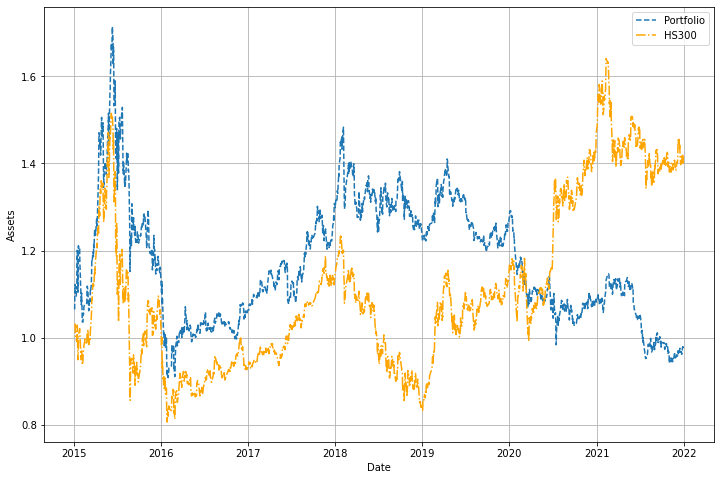

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(x_list, stock_asset, linestyle='--', label='Portfolio')
plt.plot(x_list, hs_asset, linestyle='-.', color='orange', label='HS300')
plt.xlabel('Date')
plt.ylabel('Assets')
plt.legend()
plt.grid(True)

首先可以直观地看到，基于我们的策略，我们的资产在2015年-2019年的涨跌趋势与沪深300相同，近似同涨同跌，不过我们的策略确实优于持有沪深300，比如在2015-2016年间，我们的资产价格最高可以达到初始时刻1元的160%，在2016-2018年间我们的策略的资产价值也更高。

不过在2019年之后，我们的资产价值与沪深300不再有相同的变化趋势，在2020年之后我们的策略反而不如沪深300，众所周知，沪深300是从沪深两市中挑选出规模大、流动性好，最具代表性的三百家公司共同组成的指数，指数市值已经占了A股总市值的将近60%，比较能反应市场状况，直观来看，应该是某些系统因素对市场产生了比较大的影响，导致市场发生了比较大的变化，较为久远的数据不再能够很好地指引我们设计投资组合，但由于我们一直不断使用过去五年的数据数据进行求解，因此我们的策略在2020级以后这几年中更新的比较缓慢，不太能够符合市场的变化，因此策略的收益出现了持续性下降，也不再契合代表市场的沪深指数。

从现实世界来看，可能是2018年开始的贸易战、2020年开始的新冠疫情对股票市场产生了很大影响，更加具体分析，有待进一步的学习后进行尝试。

接下来我们看一下引入无风险资产之后，会获得怎样的收益，具体的思路为首先以最大化夏普比为目标函数求解权重，然后计算6%期望收益率下的market portfolio和无风险资产的权重，然后进行测试

In [20]:
def cal_sharpe(cur_year, cur_month):
    # 首先设置约束条件，分别是各个股票权重之和等于1
    # 调用scipy函数求解过程中也要计算预期收益率
    # 计算夏普比，因此不需要这个预期6%的约束
    cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1},
    # {'type':'eq','fun':lambda x:statistics_cur_data(x)[0] - target_rate}
    )

    # 由于允许做空，所以没有bounds参数的约束条件
    bnds = None
    
    # 统计收益率、标准差，夏普比
    def statistics_cur_data(weights):
        # weight shape should be [50, 1]
        weights = np.array(weights)
        # 因为给的预期是年收益率，所以把日收益率的平均结果乘以一年的交易日期数目252
        port_return = np.sum(cur_data.mean() * weights) * 252
        port_sigma = np.sqrt(np.dot(weights.T, 
            np.dot(cur_data.cov() * 252, weights)))
        return np.array([port_return, port_sigma, (port_return - risk_free_rate) / port_sigma])
    
    def min_func_sharpe(weights):
        return -statistics_cur_data(weights)[2]
    
    print('cur_year {year} cur_month {month}'.format(year=cur_year, 
        month=cur_month))

    cur_date = datetime(cur_year, cur_month, 1)
    filter_index = (filtered_return.index >= cur_date + 
        relativedelta(years=-5)) * (filtered_return.index < cur_date)
    cur_data = filtered_return[filter_index]
    assert cur_data is not None
    
    # num_stocks * [1. / num_stocks,]可以构造出长为num_stocks的平均权重列表
    opts = sco.minimize(min_func_sharpe, num_stocks * [1. / num_stocks,], 
        method='SLSQP', bounds=bnds, constraints=cons)
    
    statistics_res = statistics_cur_data(opts['x'])

    # 获取market portfolio之后，要引入无风险利率，计算最终的投资组合权重
    market_rate = statistics_res[0]
    # 根据expect_rate = w * E(market_rate) + (1 - w) * risk_free_rate的公式得到
    weight_market = (target_rate - risk_free_rate) / (market_rate - risk_free_rate)
    
    # 开始对未来四个月进行统计计算，本函数内部只计算出来未来四个月每日的权重，把该数据return给外部，符合这一函数的作用，避免了混乱，也便于debug
    check_index = (filtered_return.index >= cur_date) * \
        (filtered_return.index <= (cur_date + relativedelta(months=4))) 
    # 沪深指数也会在作图中用到，所以也return出去
    check_HS = filtered_HS[check_index]

    check_data = filtered_return[check_index]
    # market portfolio只占了一部分
    cur_weight = opts['x'] * weight_market  
    # 再加上无风险资产得到最终的当日利率
    true_return = np.dot(check_data, cur_weight) + (1 - weight_market) * (risk_free_rate / 252)
    
    return check_data.index, true_return, check_HS

In [21]:
x_list = []
y_list = []
hs_list = []
for cur_year in range(start_year, end_year, 1):
    for cur_month in range(1, 13, 4):
        cur_x, cur_y, cur_HS = cal_sharpe(cur_year, cur_month)
        x_list.extend(cur_x.tolist())
        y_list.extend(cur_y.tolist())
        hs_list.extend(cur_HS.tolist())

cur_year 2015 cur_month 1
cur_year 2015 cur_month 5
cur_year 2015 cur_month 9
cur_year 2016 cur_month 1
cur_year 2016 cur_month 5
cur_year 2016 cur_month 9
cur_year 2017 cur_month 1
cur_year 2017 cur_month 5
cur_year 2017 cur_month 9
cur_year 2018 cur_month 1
cur_year 2018 cur_month 5
cur_year 2018 cur_month 9
cur_year 2019 cur_month 1
cur_year 2019 cur_month 5
cur_year 2019 cur_month 9
cur_year 2020 cur_month 1
cur_year 2020 cur_month 5
cur_year 2020 cur_month 9
cur_year 2021 cur_month 1
cur_year 2021 cur_month 5
cur_year 2021 cur_month 9
cur_year 2022 cur_month 1
cur_year 2022 cur_month 5
cur_year 2022 cur_month 9


In [22]:
y_list[:20]

[-0.004164394237091704,
 -0.00024399349206489813,
 -0.0023146260529504983,
 -0.0027210762310015068,
 0.0005350060943525501,
 0.0013231787053360768,
 0.0004975324272364611,
 0.0014326021944623118,
 -0.0006411141057489092,
 -0.0022771045110017525,
 -0.0005254391345250082,
 -0.0017531576415034374,
 0.0005485015082187519,
 -0.001720786160801304,
 0.0015007770740305957,
 -0.0006233288863457568,
 0.0017251650316796614,
 0.00018949540993660395,
 -0.0003359391931098584,
 -0.00031592852976779505]

In [23]:
riskfree_stock_asset = []
riskfree_hs_asset = []

start_stock = 1
start_hs = 1
for cur_y, cur_hs in zip(y_list, hs_list):
    start_stock = start_stock * (1 + cur_y)
    start_hs = start_hs * (1 + cur_hs)
    riskfree_stock_asset.append(start_stock)
    riskfree_hs_asset.append(start_hs)

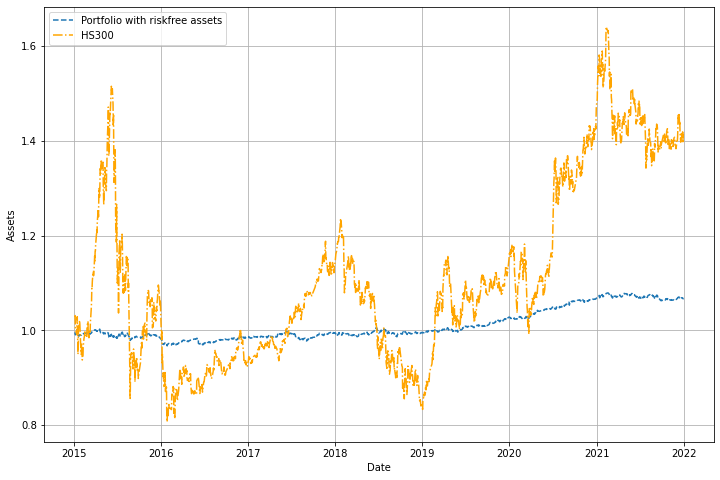

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(x_list, riskfree_stock_asset, linestyle='--', label='Portfolio with riskfree assets')
plt.plot(x_list, riskfree_hs_asset, linestyle='-.', color='orange', label='HS300')
plt.xlabel('Date')
plt.ylabel('Assets')
plt.legend()
plt.grid(True)

可以看到，引入了无风险资产之后，我们的投资组合更稳定了，与沪深300的走势更加接近（特别是在2019年之后），在最后获得了更高的收益。结合CML-有效前沿图来看，引入无风险资产使我们可以在更小的风险情况下得到相同的期望收益。从上图结果来看，无风险资产的引入可以让我们获得更大的效用。

在完成本题的过程中，我遇到了一些困难，在这里进行分析总结：
* 首先对概念不是很清晰，没有搞懂究竟要做什么，最开始我以为是要每4个月基于最高夏普比更新一次组合，然后与6%进行比较。但结合老师课件来看，我们其实是要把6%作为一个约束，求出我们的组合权重——得认识到6%是理想、预期的收益，并不是实际的（还纠结过如果是6%的话画出来的应该是一条直线，概念着实理解的不清晰，需要加强）
* 在年收益率和日收益率的使用上卡了很长时间，我在通过sco.minimize()函数求解出投资组合之后，计算了未来四个月的收益率，发现有的时候日收益率能到6%，因为要和年收益率做比较，所以我对这个6%量级的数据乘了252，以为是“年收益率”，发现数字非常大（甚至出现1600%这样的结果），花了非常长时间debug，在同学的帮助下，才反应过来不应该这么乘，因为股票价格是波动的，单日的收益可能会和初始值相差非常多，直接乘252自然会出现异常大/小的结果，之所以之前的代码中可以*252然后和预期收益率构造约束条件，是因为我们使用的是五年的历史数据平均值，在这样长的时间维度上，数据才会比较“正常”。通过这个bug，对股票价格的随机性有了更多理解

## Qustion2

首先对本题进行总体上的分析，这道题与第二节课的内容相关，需要求出各个资产的$\beta$值，整体上比较简单，我们首先计算出market portfolio的期望和方差，然后即可计算得到各个值。

对于$\alpha$，用到了老师讲的单因子模型，首先构造出线性回归的形式，然后求解即可。

下面的代码块是筛选出我们需要的数据：

In [34]:
stock_12_years = filtered_return[filtered_return.index < datetime(2022, 1, 1)].iloc[:, 0:6]  # 2010 - 2011
stock_12_years.shape

(2915, 6)

In [35]:
hs_12_years= filtered_HS[filtered_HS.index < datetime(2022, 1, 1)]
hs_12_years.shape

(2915,)

计算出market portfolio的期望和方差：

In [36]:
r_market = hs_12_years.mean()
var_market = hs_12_years.var()

为了计算协方差，把沪深指数和股票收益率数据拼接起来：

In [37]:
stock_and_HS = pd.concat([hs_12_years, stock_12_years], axis=1)

In [27]:
stock_and_HS.head()

,沪深300,600999.SH,601001.SH,601002.SH,601003.SH,601005.SH,601006.SH
2010-01-06,-0.006260,-0.022366,0.014396,-0.023486,0.044525,0.006920,0.000984
2010-01-07,-0.019841,-0.008289,-0.019911,-0.035443,-0.021889,-0.025773,-0.021632
2010-01-08,0.002498,0.020729,-0.023125,0.013123,-0.017668,0.047619,-0.001005
2010-01-11,0.000552,0.022273,-0.015708,-0.010363,0.020384,0.020202,0.002012
2010-01-12,0.015184,0.004806,0.008092,0.022251,0.021152,0.001650,0.039157


In [38]:
stock_and_HS.cov()

,沪深300,600999.SH,601001.SH,601002.SH,601003.SH,601005.SH,601006.SH
沪深300,0.000205,0.000265,0.000235,0.000235,0.000166,0.000170,0.000149
600999.SH,0.000265,0.000629,0.000295,0.000277,0.000197,0.000200,0.000187
601001.SH,0.000235,0.000295,0.000853,0.000331,0.000295,0.000310,0.000177
601002.SH,0.000235,0.000277,0.000331,0.000888,0.000253,0.000274,0.000183
601003.SH,0.000166,0.000197,0.000295,0.000253,0.000681,0.000326,0.000129
601005.SH,0.000170,0.000200,0.000310,0.000274,0.000326,0.000619,0.000149
601006.SH,0.000149,0.000187,0.000177,0.000183,0.000129,0.000149,0.000277


进行$\beta$值的计算：

In [39]:
beta = stock_and_HS.cov().iloc[0] / var_market
beta

沪深300        1.000000
600999.SH    1.288043
601001.SH    1.142850
601002.SH    1.145810
601003.SH    0.809127
601005.SH    0.825468
601006.SH    0.724732
Name: 沪深300, dtype: float64

接下来进行线性回归，求解$\alpha$：

In [30]:
(stock_and_HS - risk_free_rate).head()

,沪深300,600999.SH,601001.SH,601002.SH,601003.SH,601005.SH,601006.SH
2010-01-06,-0.036260,-0.052366,-0.015604,-0.053486,0.014525,-0.023080,-0.029016
2010-01-07,-0.049841,-0.038289,-0.049911,-0.065443,-0.051889,-0.055773,-0.051632
2010-01-08,-0.027502,-0.009271,-0.053125,-0.016877,-0.047668,0.017619,-0.031005
2010-01-11,-0.029448,-0.007727,-0.045708,-0.040363,-0.009616,-0.009798,-0.027988
2010-01-12,-0.014816,-0.025194,-0.021908,-0.007749,-0.008848,-0.028350,0.009157


求解线性回归，用到了scipy库：

In [41]:
import scipy.stats as st

In [42]:
beta_list = []
alpha_list = []
p_value_list = []

# 股票下标1到6
for i in range(1, 7, 1):
    y = (stock_and_HS - risk_free_rate).iloc[:, i]  # 第i支股票
    x = (stock_and_HS - risk_free_rate).iloc[:, 0]  # market portfolio
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

    beta_list.append(slope)
    alpha_list.append(intercept)
    p_value_list.append(p_value)


下面几个代码块是查看得到的结果，首先看$\beta$，可以看到拟合出来的结果和我们之前通过计算协方差直接代入公式得到的结果非常接近，验证了单因子模型的正确性，也说明代码没有bug：

In [43]:
beta_list

[1.2880428334033085,
 1.142849966656091,
 1.1458103654216962,
 0.8091273827241589,
 0.8254681180823079,
 0.7247316475815156]

单因子模型的公式中还有误差项$\epsilon$，在回归的时候无法把它和$\alpha$分离开，所以得到的$\alpha$并不是精准的0，不过还是非常接近0的:

In [44]:
alpha_list

[0.008487329450354159,
 0.003946852751496872,
 0.004418403322658443,
 -0.005720052599886841,
 -0.0054552167818409,
 -0.0084334357615677]

根据题目的要求，需要对显著水平进行查看，scipy函数的返回值中提供了p值，可以看到都是非常小的值，远小于题干要求的5%（1-95%），所以在95% level上可以认为$\alpha$为0：

In [35]:
p_value_list

[0.0,
 3.0939606864032126e-241,
 2.3991198576000861e-231,
 2.8289337718573925e-141,
 1.501711419912621e-164,
 8.437032227e-315]

与此同时，我们可以对数据进行可视化查看，看看它们是不是直观上符合一个线性关系，以下6张图为可视化结果，可以看到总体上还是呈现一个线性趋势的，另外第二支股票中出现了一个异常点，所以导致大多数点都集中在了图片的上方部分：

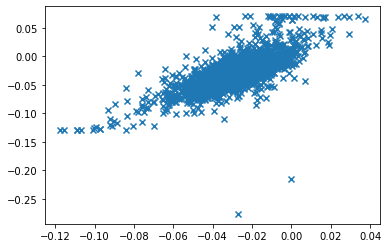

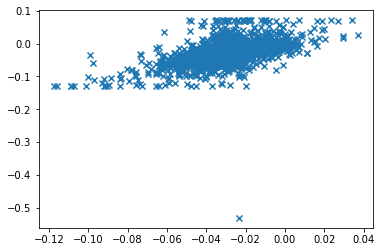

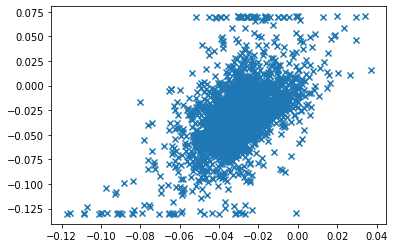

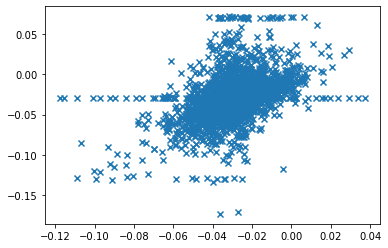

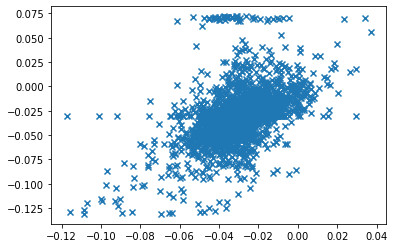

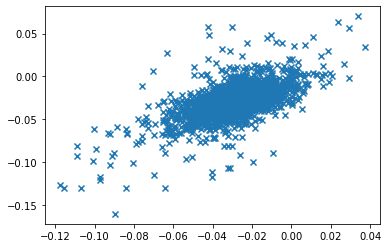

In [36]:
# 股票下标1到6
for i in range(1, 7, 1):
    y = (stock_and_HS - risk_free_rate).iloc[:, i]  # 第i支股票
    x = (stock_and_HS - risk_free_rate).iloc[:, 0]  # market portfolio
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    plt.scatter(x, y, marker='x')
    plt.show()

## Question3

### 3(1)

首先对这一问进行总体的分析，题干的要求是构造出binomial tree，对资产进行定价。根据课堂所讲授的内容，我们需要先进行一个“前向传播”过程计算出相应股票的价格，然后“反向传播”计算出期权的价格。

首先设定基本的数据：

In [37]:
total_time = 18 # 18 months
vol_annum = 0.4
risk_free_rate = 0.03
strike_price = 40
start_price = 40

设置一个函数来建树，便于计算不同的step。

讲binomial tree的时候，老师课件定义的“两步二叉树”实际上是一个“层数为3”的树，因此我这里理解为题干要求的step=100实际上是一个101层的结构，因此计算的时候把参数设置成了10+1，50+1，100+1

具体细节上，binomial tree的规律是构造出来的二叉树实际上可以看成一个下三角矩阵，有这样的规律：

$stock\_price\_tree[i + 1][j + 1] = u * stock\_price\_tree[i][j]$

$stock\_price\_tree[i + 1][0] = d * stock\_price\_tree[i][0]$

通过这样的规律，可以前向传播计算出股票的价格。

对于期权价格，有这样的规律：

$option\_return[i - 1][j - 1] = discount * (p * option\_return[i][j] + (1 - p) * option\_return[i][j - 1])$

其中，discount为$e^{-r * T}$，r是无风险利率

In [38]:
def gen_binomial_tree(total_time, vol_annum, risk_free_rate, strike_price, start_price, step_num):
    time_to_maturity = total_time / 12.0
    # step_num ==3 3层二叉树，应该只有2个interval
    interval_per_step = (total_time / (step_num - 1)) / 12.0  # 每个step几个月，等价于几分之一年
    u = math.exp(vol_annum * math.sqrt(interval_per_step))
    d = 1 / u
    p = (np.exp(risk_free_rate * interval_per_step) - d) / (u - d)
    discount = np.exp(-1 * risk_free_rate * interval_per_step)

    stock_price_tree = np.zeros((step_num + 1, step_num + 1))
    option_return = np.zeros((step_num + 1, step_num + 1))

    stock_price_tree[0][0] = start_price
    
    for i in range(step_num):
        for j in range(i + 1):
            stock_price_tree[i + 1][j + 1] = u * stock_price_tree[i][j]
        stock_price_tree[i + 1][0] = d * stock_price_tree[i][0]

    for i in range(step_num, 0, -1):
        for j in range(i, 0, -1):
            if i == step_num:
                option_return[i - 1][j - 1] = max(strike_price - 
                    stock_price_tree[i - 1][j - 1], 0)
            else:
                option_return[i - 1][j - 1] = discount * \
                    (p * option_return[i][j] + (1 - p) * option_return[i][j - 1])
    
    print('m取{step}steps price: {price}'.format(step=step_num, 
        price=option_return[0][0]))

In [39]:
gen_binomial_tree(total_time, vol_annum, 
    risk_free_rate, strike_price, start_price, 10+1)

m取11steps price: 6.5338342816600115


In [40]:
gen_binomial_tree(total_time, vol_annum, 
    risk_free_rate, strike_price, start_price, 50+1)

m取51steps price: 6.683205997599162


In [41]:
gen_binomial_tree(total_time, vol_annum, 
    risk_free_rate, strike_price, start_price, 100+1)

m取101steps price: 6.702124331429704


In [42]:
gen_binomial_tree(total_time, vol_annum, 
    risk_free_rate, strike_price, start_price, 1000+1)

m取1001steps price: 6.719192964428938


In [43]:
gen_binomial_tree(total_time, vol_annum, 
    risk_free_rate, strike_price, start_price, 5000+1)

m取5001steps price: 6.720712062262431


通过上面设置不同steps计算结果，可以看到整体上price逐渐收敛于6.721。

接下来通过BSM定价公式来与此进行对比，如果没有出现bug，那么计算得到的结果应该非常接近。为了计算正态分布累计函数，调用了scipy.stats中的norm()函数

In [44]:
from scipy.stats import norm

具体计算上，只要根据课本中的公式，编写函数即可：

In [45]:
def cal_BSM(start_price, strike_price, risk_free_rate, vol_annum, total_time):
    time_to_maturity = total_time / 12.0
    
    # 分别计算分子的两项，分母的一项
    ln_s0_div_K_term = math.log(start_price / strike_price)
    r_add_var_term = (risk_free_rate + 
        0.5 * vol_annum * vol_annum) * time_to_maturity
    r_sub_var_term = (risk_free_rate - 
        0.5 * vol_annum * vol_annum) * time_to_maturity
    divided_term = vol_annum * math.sqrt(time_to_maturity)

    d1 = (ln_s0_div_K_term + r_add_var_term) / divided_term
    d2 = (ln_s0_div_K_term + r_sub_var_term) / divided_term

    k_e_neg_rT = strike_price * \
        math.exp(-1 * risk_free_rate * time_to_maturity)
    n_d1 = norm.cdf(-1 * d1)
    n_d2 = norm.cdf(-1 * d2)

    BSM_result = k_e_neg_rT * n_d2 - start_price * n_d1
    return BSM_result


可以看到，下面的结果也非常接近6.721，观察基于binomial tree得到的结果，确实随着steps的增加，得到的价格逐渐接近6.721，验证了steps趋近无限时，确实会由binomial tree模型得到BSM模型：

In [46]:
cal_BSM(start_price, strike_price, risk_free_rate, vol_annum, total_time)

6.721091884244682

### 3(2)

这一问是要构造美式期权，和上一问唯一的区别在于反向传播过程，在每个节点都要计算一下期权的收益，然后在基于binomial tree定价得到的价格和这个收益中取一个较大的，其余地方没有区别：

In [2]:
def gen_American_binomial_tree(total_time, vol_annum, risk_free_rate, strike_price, start_price, step_num):
    time_to_maturity = total_time / 12.0
    # 注意这里得step - 1!!
    interval_per_step = (total_time / (step_num - 1)) / 12.0  # 每个step几个月，等价于几分之一年
    u = math.exp(vol_annum * math.sqrt(interval_per_step))
    d = 1 / u
    p = (np.exp(risk_free_rate * interval_per_step) - d) / (u - d)
    discount = np.exp(-1 * risk_free_rate * interval_per_step)

    stock_price_tree = np.zeros((step_num + 1, step_num + 1))
    option_return = np.zeros((step_num + 1, step_num + 1))

    stock_price_tree[0][0] = start_price
    
    for i in range(step_num):
        for j in range(i + 1):
            stock_price_tree[i + 1][j + 1] = u * stock_price_tree[i][j]
        stock_price_tree[i + 1][0] = d * stock_price_tree[i][0]

    for i in range(step_num, 0, -1):
        for j in range(i, 0, -1):
            if i == step_num:
                option_return[i - 1][j - 1] = max(strike_price 
                    - stock_price_tree[i - 1][j - 1], 0)
            else:
                # 随时可以行权
                candidate1 = discount * \
                    (p * option_return[i][j] + (1 - p) * option_return[i][j - 1])
                candidate2 = max(strike_price 
                    - stock_price_tree[i - 1][j - 1], 0)
                option_return[i - 1][j - 1] = max(candidate1, candidate2)
    # print(option_return)
    print('美式期权下，m取{step}steps price: {price}'.format(step=step_num, 
        price=option_return[0][0]))

In [48]:
total_time = 18 # 18 months
vol_annum = 0.4
risk_free_rate = 0.03
strike_price = 40
start_price = 40

调用函数，得到最终的结果为6.897，其它数据相同的情况下，美式期权确实比欧式期权的价格更贵一些，印证了老师课堂上讲的“因为美式期权可以随时行权，收益会更大，所以会更贵”的正确性：

In [49]:
gen_American_binomial_tree(total_time, vol_annum, 
    risk_free_rate, strike_price, start_price, 100 + 1)

美式期权下，m取101steps price: 6.897469827663967


此外，用书上213页12-10计算美式看跌期权的例子对本函数进行验算，结果无误：

In [50]:
total_time = 24
vol_annum = 0.3
risk_free_rate = 0.05
strike_price = 52
start_price = 50

In [51]:
gen_American_binomial_tree(total_time, vol_annum, 
    risk_free_rate, strike_price, start_price, 2 + 1)

美式期权下，m取3steps price: 7.428401902704834


再用note3的例子测试一下，结果无误：

In [3]:
total_time = 5
vol_annum = 0.4
risk_free_rate = 0.1
strike_price = 50.0
start_price = 50.0

In [4]:
gen_American_binomial_tree(total_time, vol_annum, 
    risk_free_rate, strike_price, start_price, 5 + 1)

美式期权下，m取6steps price: 4.488458534725914
